In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from utils.FeatureExtractor import get_vector_representation,prepare_projection
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass
# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
# 4. Wandb Tracker Experiements
import wandb

In [2]:
DATA_PATH = '../data/microscopy_v1.csv'
BASE_PATH = Path('/mnt')
BASE_IMG_DIR = BASE_PATH 
SEED = 42
model_path = '/mnt/artifacts/models/Microscopy/microscopy_v1.pt'

In [3]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder,dict_label = label_encoder_target(df,target_col='modality')
dict_label

{'DMEL': 0, 'DMFL': 1, 'DMLI': 2, 'DMTR': 3}

In [4]:
# 3.1 Load the Resnet Model
model = ResNetClass.load_from_checkpoint(model_path)
print('*'*5,' Resnet Model Parameters ','*'*5)
print(model.hparams)
print('*'*5,' Resnet Model Children ','*'*5)
children_counter = 0
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

*****  Resnet Model Parameters  *****
"class_weights":   [2.26334951 0.63349185 0.71074695 1.74625468]
"fine_tuned_from": whole
"lr":              1e-05
"mean_dataset":    [0.49269813 0.47998244 0.48252493]
"metric_monitor":  val_avg_loss
"mode_scheduler":  min
"name":            resnet18
"num_classes":     4
"pretrained":      True
"std_dataset":     [0.3624665  0.35439512 0.3654343 ]
*****  Resnet Model Children  *****
Children Counter:  0  Layer Name:  model


In [5]:
prepare_projection(model,le_encoder,DATA_PATH,BASE_IMG_DIR,SEED,CLASSF ='microscopy' ,VERSION = 1)

Feature Vector for training: 



Feature Vector for Validation: 



Feature Vector for Test: 



***** PCA *****
***** UMAP *****


In [2]:
import pandas as pd
df_projection = pd.read_parquet( '/mnt/artifacts/projections/microscopy_v1.parquet')

,img,modality,set,source,img_path,higher_modality,caption,split_set,target,feature_vector,pca_x,pca_y,pca_hits,umap_x,umap_y,umap_hits,target_predicted
0,11373_2007_9226_Fig1_HTML-10.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN,DMFL,"[0.73454773, 2.3189375, 1.8159454, 2.217777, 0...",-13.401747,2.960867,1.0,1.414287,6.751490,1.0,DMFL
1,11373_2007_9226_Fig1_HTML-11.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN,DMFL,"[1.6500967, 0.44767615, 0.26605338, 1.2194066,...",-11.423889,0.435897,1.0,0.157938,6.711448,1.0,DMFL
2,11373_2007_9226_Fig1_HTML-12.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN,DMFL,"[0.18766804, 0.8882037, 0.17471713, 1.6783041,...",-11.434527,1.691029,1.0,0.525126,6.558390,1.0,DMFL
3,11373_2007_9226_Fig1_HTML-13.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN,DMFL,"[0.98631316, 0.94031405, 1.5821327, 2.024434, ...",-12.130900,2.160552,1.0,-0.436258,6.315166,1.0,DMFL
4,11373_2007_9226_Fig1_HTML-14.jpg,DMFL,TRAIN,clef16,subfigure-classification/2016/train/DMFL/11373...,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN,DMFL,"[0.49255484, 1.3853208, 0.63163185, 1.8374391,...",-11.367564,2.537785,1.0,1.626503,6.568087,1.0,DMFL


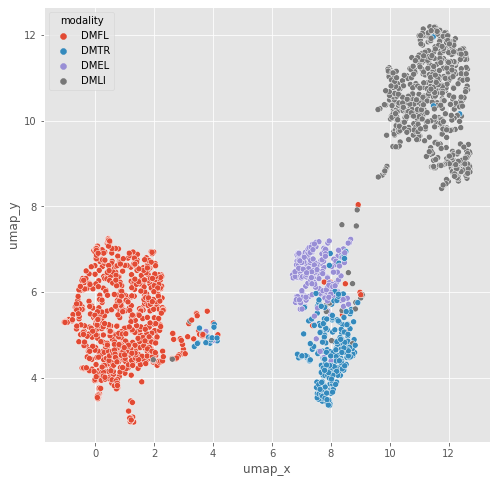

In [8]:
plt.figure(figsize=(8,8))
df1 = df_projection[df_projection['split_set']=='TRAIN'].reset_index(drop = True)
sns.scatterplot(data=df1, x="umap_x", y="umap_y", hue="modality")
plt.show()